In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cmocean
import oceans
import csv
import gsw
import glob
%matplotlib inline 

/anaconda/lib/python3.6/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from cartopy.io.img_tiles import OSM
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
#path lists for files (thanks for telling me about glob because I usually use wget!)
list_of_paths = sorted(glob.glob('Argentine/argo_download/**/**/**/*.nc'))

In [4]:
len(list_of_paths)

10905

In [5]:
#Open all the files and store the Latitude, Longitude, and Temperature (averaged over the 36.3 to 36.8 sigma2 range) 
#for each profile (in principle you could save other fields i.e. sal averaged over isopycnal range)
Lon=[];
Lat=[];
Temp=[];
Temp365=[];
Sal365=[];

for i in range(len(list_of_paths)):
    fd=xr.open_mfdataset(list_of_paths[i])
    Lat.append(fd.LATITUDE.values[0])
    Lon.append(fd.LONGITUDE.values[0])
    
    #calculate sigma2
    SA=gsw.SA_from_SP(fd.PSAL_ADJUSTED[0].values,fd.PRES_ADJUSTED[0].values,fd.LONGITUDE[0].values,fd.LATITUDE[0].values)
    CT=gsw.CT_from_t(SA,fd.TEMP_ADJUSTED[0].values,fd.PRES_ADJUSTED[0].values)
    SIG2=gsw.sigma2(SA,CT)
    
    #interpolate temperature onto constant sigma2 grid
    zi = np.arange(34.4, 36.8, 0.01)
    temp_int=np.interp(zi, SIG2, fd.TEMP_ADJUSTED[0].values)
    sal_int=np.interp(zi, SIG2, fd.PSAL_ADJUSTED[0].values)
    
    #not all profiles get as dense as sigma2=36.8, which leads to repeated values in temp_int 
    #you need to get rid of these repeated values so they don't affect the mean
    #this block of code finds the indices of the repeated values
    vals, inverse, count = np.unique(temp_int, return_inverse=True,
                              return_counts=True)

    idx_vals_repeated = np.where(count > 1)[0]
    vals_repeated = vals[idx_vals_repeated]

    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
    _, inverse_rows = np.unique(rows, return_index=True)
    res = np.split(cols, inverse_rows[1:]) #res gives the indices of the repeated values
    
    temp_int[res[0]]=np.nan #set the repeated values to nans
    sal_int[res[0]]=np.nan #set the repeated values to nans
    
    #save temperature averaged over the 36.3 to 36.8 sig2 range for each profile 
    Temp.append(np.nanmean(temp_int[190:240]))
    
    #save temperature and salinity on the 36.5 isopycnal for each profile 
    Temp365.append(np.nanmean(temp_int[210]))
    Sal365.append(np.nanmean(sal_int[210]))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


In [6]:
#Convert the stored Lat,Lon,Temp data into an array
Temp=np.asarray(Temp)
Temp365=np.asarray(Temp365)
Sal365=np.asarray(Sal365)
Lat=np.asarray(Lat)
Lon=np.asarray(Lon)

#quality control issue, quick fix is to set unrealistic values to nan
Temp[Temp>6]=np.nan
Temp365[Temp365>6]=np.nan
Sal365[Sal365>35]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [7]:
#Only take the profiles where Temperature is not nan (otherwise the binned averages don't work)
Lat_all = Lat[~np.isnan(Temp)]
Lon_all = Lon[~np.isnan(Temp)]
Temp = Temp[~np.isnan(Temp)]

Lat365 = Lat[~np.isnan(Temp365)]
Lon365 = Lon[~np.isnan(Temp365)]
Temp365 = Temp365[~np.isnan(Temp365)]
Sal365 = Sal365[~np.isnan(Sal365)]

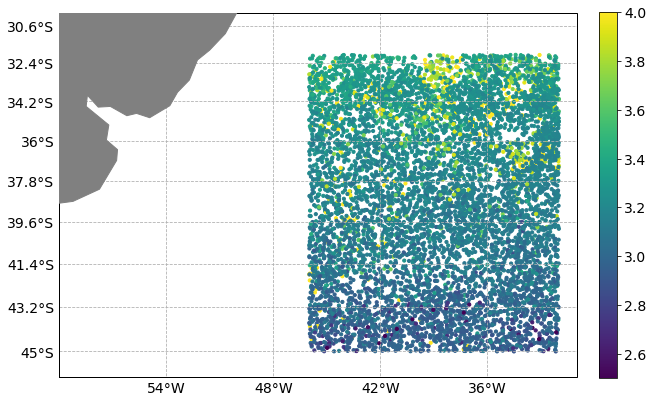

In [14]:
#PLOT A MAP OF PROFILE LOCATION (colored by temperature averaged over the 36.3 to 36.8 sigma2 range) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

cs=ax.scatter(Lon_all,Lat_all,c=Temp,s=10,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0328, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
cs.set_clim(2.5, 4)
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

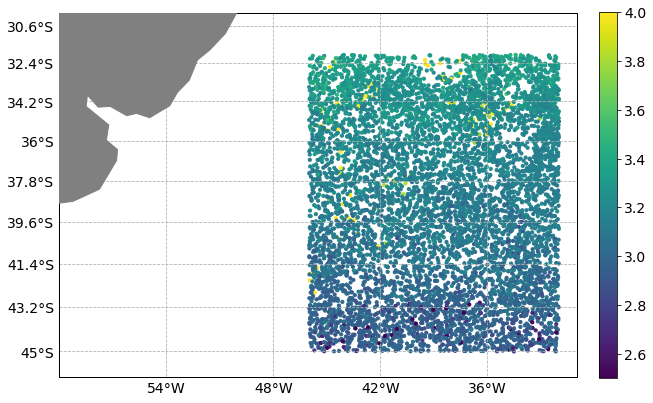

In [15]:
#PLOT A MAP OF PROFILE LOCATION (colored by temperature on the 36.5 isopycnal) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

cs=ax.scatter(Lon365,Lat365,c=Temp365,s=10,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0328, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
cs.set_clim(2.5, 4)
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

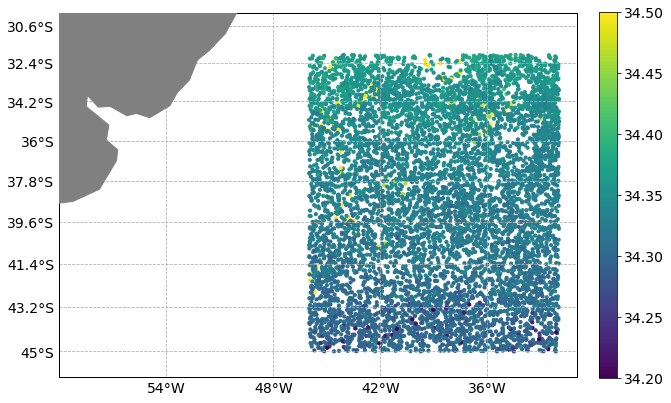

In [20]:
#PLOT A MAP OF PROFILE LOCATION (colored by salinity on the 36.5 isopycnal) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

cs=ax.scatter(Lon365,Lat365,c=Sal365,s=10,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0328, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
cs.set_clim(34.2, 34.5)
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

In [23]:
#FIND AVERAGES BY 1 DEGREE BOXES (on 36.5 isopycnal)
#set lat/lon boundaries for grid and grid spacing
xbins = np.arange(-45,-31,1)
ybins = np.arange(-45,-31,1)
#define a gridded array of all zeros that is the same shape as the lat/lon grid for temperature in each grid box
Tgrid = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})
Sgrid = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})
#define a gridded array of all zeros that is the same shape as the lat/lon grid for number of profiles in each grid box
nDATA = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})

Tgrid=Tgrid.astype(float)
Sgrid=Sgrid.astype(float)

#sort each profile by grid box and store the temperatures and number of profiles in each box
for i in range(len(Temp365)):
    ix = np.nanargmin(np.abs(xbins-Lon365[i]))
    iy = np.nanargmin(np.abs(ybins-Lat365[i]))
    if Lon365[i]<xbins[ix]:
        if Lat365[i]<ybins[iy]:
            Tgrid[iy-1,ix-1] = Tgrid[iy-1,ix-1]+Temp365[i]
            Sgrid[iy-1,ix-1] = Sgrid[iy-1,ix-1]+Sal365[i]
            nDATA[iy-1,ix-1] += 1
        else:
            Tgrid[iy,ix-1] = Tgrid[iy,ix-1]+Temp365[i]
            Sgrid[iy,ix-1] = Sgrid[iy,ix-1]+Sal365[i]
            nDATA[iy,ix-1] += 1
    else:
        if Lat365[i]<ybins[iy]:
            Tgrid[iy-1,ix] = Tgrid[iy-1,ix]+Temp365[i]
            Sgrid[iy-1,ix] = Sgrid[iy-1,ix]+Sal365[i]
            nDATA[iy-1,ix] += 1
        else:
            Tgrid[iy,ix] = Tgrid[iy,ix]+Temp365[i]
            Sgrid[iy,ix] = Sgrid[iy,ix]+Sal365[i]
            nDATA[iy,ix] += 1

In [24]:
#CALCULATE THE MEAN IN EACH GRID BOX
#Tgrid is a sum of all the temperature values from all the profiles in a given grid box so need to divide by the 
#number of profiles in each grid box to get the mean temperature 
T365mean=Tgrid/nDATA
S365mean=Sgrid/nDATA

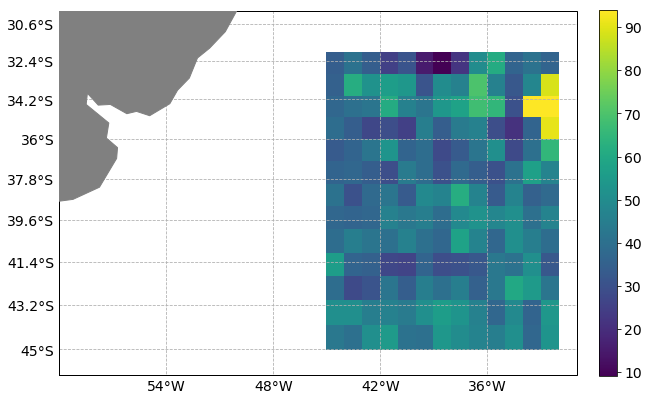

In [25]:
#PLOT THE NUMBER OF PROFILES IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

h=ax.pcolor(xbins,ybins,nDATA,transform=ccrs.PlateCarree()) #plot a
#contour map of the chlorophyll data (set values to range from 0 to 1 mg/m3 and use Greens colormap)
cb=fig.colorbar(h, fraction=0.0328, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

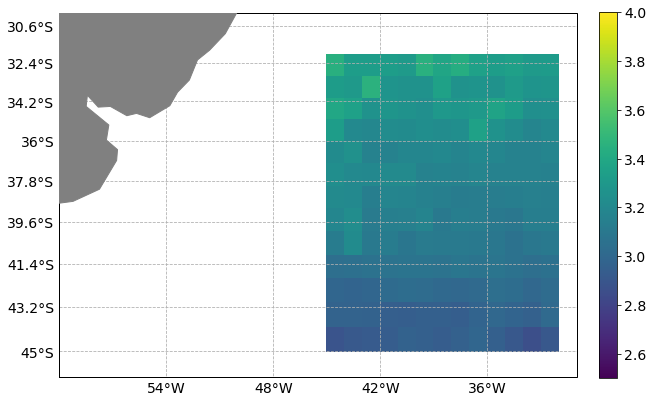

In [27]:
#PLOT THE AVERAGE TEMPERATURE (FOR 36.5 ISOPYCNAL) IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

h=ax.pcolor(xbins,ybins,T365mean,vmin=2.5,vmax=4,transform=ccrs.PlateCarree()) #plot a
#contour map of the chlorophyll data (set values to range from 0 to 1 mg/m3 and use Greens colormap)
cb=fig.colorbar(h, fraction=0.0328, pad=0.04)#,extend='both') #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

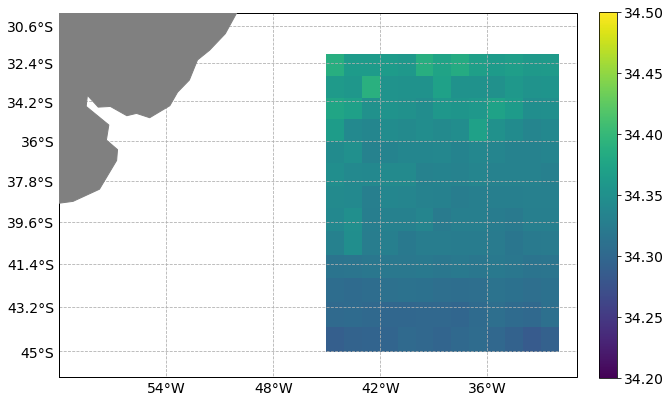

In [28]:
#PLOT THE AVERAGE SALINITY (FOR 36.5 ISOPYCNAL) IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

h=ax.pcolor(xbins,ybins,S365mean,vmin=34.2,vmax=34.5,transform=ccrs.PlateCarree()) #plot a
#contour map of the chlorophyll data (set values to range from 0 to 1 mg/m3 and use Greens colormap)
cb=fig.colorbar(h, fraction=0.0328, pad=0.04)#,extend='both') #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}